In [2]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Load the clustering-ready data
clustering_df = pd.read_csv('clustering_data.csv')

# Retain track_id separately
track_id = clustering_df['track_id']

# Drop track_id before clustering
clustering_features = clustering_df.drop(columns=['track_id'])


# Check the shape and columns
print(f"Shape of data: {clustering_features.shape}")
print(f"Columns: {clustering_features.columns}")

# clustering_df['track_id'] = track_id


Shape of data: (89740, 15)
Columns: Index(['popularity', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature', 'duration_sec', 'num_artists'],
      dtype='object')


## Preprocessing for Similarity Matrix Construction

Given the large size of the dataset, we work with a sampled subset to construct the cosine similarity matrix. Processing the entire dataset would be computationally prohibitive, potentially leading to system crashes due to memory constraints. This step involves sampling the data, calculating pairwise similarities between tracks based on their features, and ensuring the resulting matrix is symmetric, free of NaN values, and cleaned of negative or redundant entries. This preprocessing step is essential for enabling efficient and accurate graph-based clustering methods.

In [3]:
# Sample a subset of the data
sampled_data = clustering_features.sample(n=30000, random_state=42)  # Adjust n as needed

# Compute cosine similarity on the subset
similarity_matrix = cosine_similarity(sampled_data)

# Check the properties of the similarity matrix
print(f"Similarity matrix shape: {similarity_matrix.shape}")
print(f"Is symmetric: {np.allclose(similarity_matrix, similarity_matrix.T, atol=1e-8)}")
print(f"Contains negative values: {np.any(similarity_matrix < 0)}")

# Check for NaN values
print(f"Number of NaN values in the similarity matrix: {np.isnan(similarity_matrix).sum()}")

# Locate rows/columns with NaN values
nan_rows = np.isnan(similarity_matrix).any(axis=1)
print(f"Rows with NaN values: {np.where(nan_rows)}")


# Replace NaN values with 0
similarity_matrix = np.nan_to_num(similarity_matrix, nan=0.0)


# Symmetrize the matrix (in case it's not already symmetric)
similarity_matrix = (similarity_matrix + similarity_matrix.T) / 2

# Clip negative values (if any)
similarity_matrix = np.clip(similarity_matrix, 0, None)

# Check for zero-variance columns in the clustering features
zero_variance_columns = clustering_features.var(axis=0) == 0
print(f"Zero-variance columns: {clustering_features.columns[zero_variance_columns]}")

# Remove zero-variance columns if any
clustering_features = clustering_features.loc[:, ~zero_variance_columns]



Similarity matrix shape: (30000, 30000)
Is symmetric: True
Contains negative values: True
Number of NaN values in the similarity matrix: 0
Rows with NaN values: (array([], dtype=int64),)
Zero-variance columns: Index([], dtype='object')


In [4]:
from sklearn.cluster import SpectralClustering

# Step 3: Perform Spectral Clustering
n_clusters = 5  # Define the number of clusters
spectral_cluster = SpectralClustering(
    n_clusters=n_clusters,
    affinity='precomputed',  # Use the precomputed similarity matrix
    random_state=42
)

# Fit and predict cluster labels for the sampled data
spectral_labels = spectral_cluster.fit_predict(similarity_matrix)

# Step 4: Assign cluster labels to the sampled subset
# Create a DataFrame for the sampled data
sampled_df = clustering_df.loc[sampled_data.index].copy()

# Add Spectral Clustering labels to the sampled DataFrame
sampled_df['SpectralCluster'] = spectral_labels

# Save clustering results for the sampled subset
sampled_df.to_csv('spectral_clustering_sampled_results.csv', index=False)

# Analyze cluster distribution for the sampled subset
print("Spectral Clustering Cluster Distribution (Sampled Data):")
print(sampled_df['SpectralCluster'].value_counts())

# Optional Step 5: Merge sampled results back into the original dataset
# Initialize 'SpectralCluster' column in the full DataFrame with NaN
clustering_df['SpectralCluster'] = np.nan

# Assign cluster labels from the sampled subset to the original DataFrame
clustering_df.loc[sampled_df.index, 'SpectralCluster'] = sampled_df['SpectralCluster']

# Save the full DataFrame with clustering labels (NaN for unsampled rows)
clustering_df.to_csv('spectral_clustering_results_full.csv', index=False)

print("Clustering results have been saved.")

Spectral Clustering Cluster Distribution (Sampled Data):
SpectralCluster
3    6772
2    6678
0    6238
4    6169
1    4143
Name: count, dtype: int64
Clustering results have been saved.


In [5]:
import networkx as nx
from scipy.sparse import csr_matrix
from community import community_louvain

# Function to create a sparse graph from a similarity matrix
def create_sparse_graph(similarity_matrix, threshold=0.8):
    """
    Create a sparse graph by thresholding the similarity matrix.
    """
    similarity_matrix = np.copy(similarity_matrix)
    similarity_matrix[similarity_matrix < threshold] = 0  # Thresholding
    sparse_matrix = csr_matrix(similarity_matrix)  # Convert to sparse format
    return nx.from_scipy_sparse_array(sparse_matrix)

# Generate the graph (tune the threshold for sparsity)
similarity_graph = create_sparse_graph(similarity_matrix, threshold=0.8)

# Apply Louvain algorithm
louvain_partition = community_louvain.best_partition(similarity_graph)

# Map Louvain cluster labels to the sampled data
sampled_df['LouvainCluster'] = sampled_df.index.map(louvain_partition)

# Save Louvain clustering results for the sampled data
sampled_df.to_csv('louvain_clustering_sampled_results.csv', index=False)

# Analyze Louvain cluster distribution in the sampled data
print("Louvain Clustering Cluster Distribution (Sampled Data):")
print(sampled_df['LouvainCluster'].value_counts())


Louvain Clustering Cluster Distribution (Sampled Data):
LouvainCluster
1.0     2004
0.0     1439
5.0     1273
4.0     1236
7.0      739
17.0     675
6.0      568
8.0      485
3.0      478
2.0      474
9.0      314
12.0     249
64.0       1
26.0       1
49.0       1
18.0       1
15.0       1
48.0       1
38.0       1
60.0       1
19.0       1
33.0       1
61.0       1
16.0       1
24.0       1
27.0       1
34.0       1
13.0       1
28.0       1
Name: count, dtype: int64


Spectral Clustering Distribution (Sampled Data):
SpectralCluster
3    6772
2    6678
0    6238
4    6169
1    4143
Name: count, dtype: int64

Louvain Clustering Distribution (Sampled Data):
LouvainCluster
1.0     2004
0.0     1439
5.0     1273
4.0     1236
7.0      739
17.0     675
6.0      568
8.0      485
3.0      478
2.0      474
9.0      314
12.0     249
64.0       1
26.0       1
49.0       1
18.0       1
15.0       1
48.0       1
38.0       1
60.0       1
19.0       1
33.0       1
61.0       1
16.0       1
24.0       1
27.0       1
34.0       1
13.0       1
28.0       1
Name: count, dtype: int64


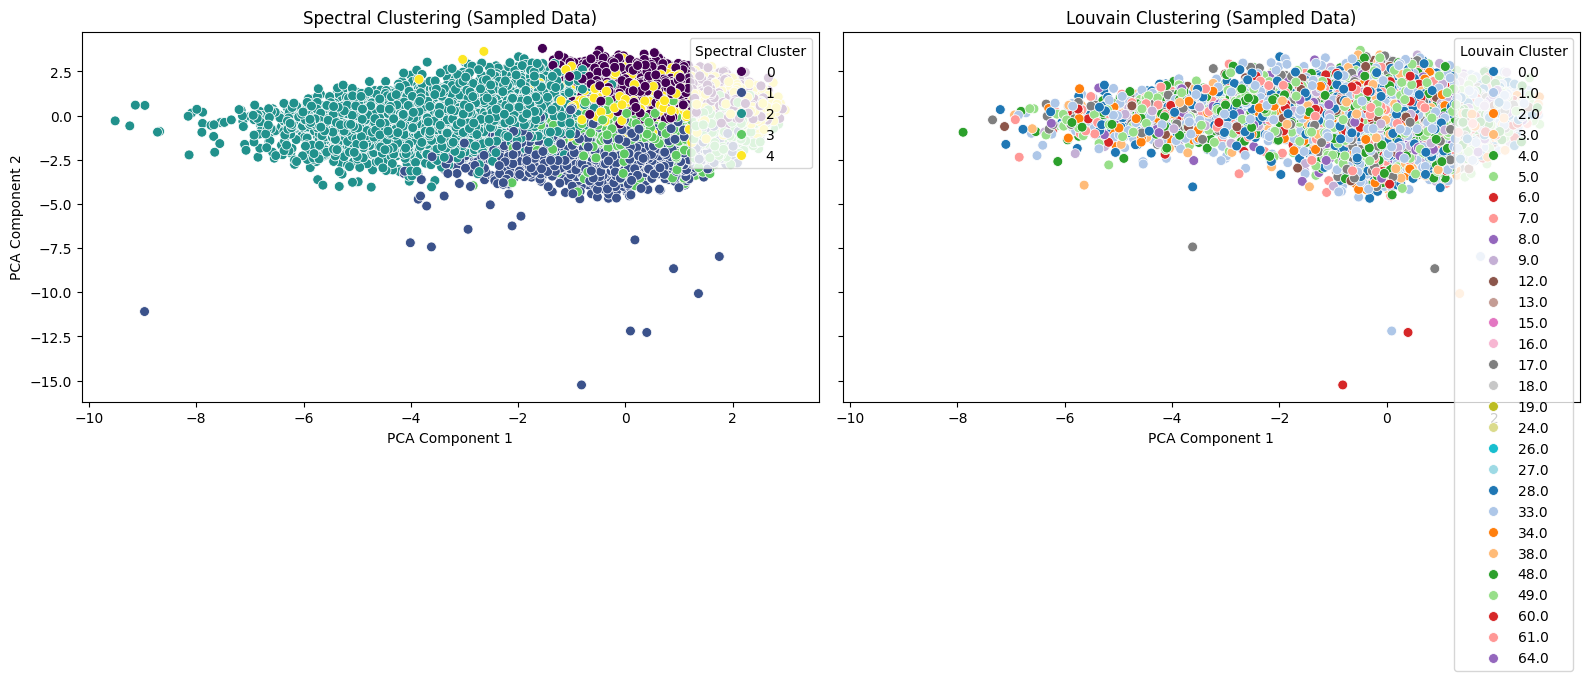

In [7]:

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Compare cluster distributions
spectral_counts = sampled_df['SpectralCluster'].value_counts()
louvain_counts = sampled_df['LouvainCluster'].value_counts()

# Print cluster distributions
print("Spectral Clustering Distribution (Sampled Data):")
print(spectral_counts)
print("\nLouvain Clustering Distribution (Sampled Data):")
print(louvain_counts)

# Perform PCA on the sampled data (without clustering labels)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(sampled_data)  # Use sampled_data (only features)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)

# Spectral Clustering Plot
sns.scatterplot(
    ax=axes[0], 
    x=X_pca[:, 0], 
    y=X_pca[:, 1], 
    hue=sampled_df['SpectralCluster'], 
    palette="viridis", 
    s=50
)
axes[0].set_title("Spectral Clustering (Sampled Data)")
axes[0].set_xlabel("PCA Component 1")
axes[0].set_ylabel("PCA Component 2")
axes[0].legend(title="Spectral Cluster", loc="upper right")

# Louvain Clustering Plot
sns.scatterplot(
    ax=axes[1], 
    x=X_pca[:, 0], 
    y=X_pca[:, 1], 
    hue=sampled_df['LouvainCluster'], 
    palette="tab20", 
    s=50
)
axes[1].set_title("Louvain Clustering (Sampled Data)")
axes[1].set_xlabel("PCA Component 1")
axes[1].legend(title="Louvain Cluster", loc="upper right")

# Adjust layout
plt.tight_layout()
plt.show()


Spectral Clustering Plot (Left): The data points are grouped into 5 distinct clusters (labeled 0 to 4), demonstrating clear boundaries and separations based on the similarity matrix. The clusters are relatively compact, showing good differentiation among them.

Louvain Clustering Plot (Right): Louvain clustering creates more granular clusters, with a larger number of groups (multiple distinct colors). This method captures more subtle divisions but may appear less distinct due to overlapping and fragmented clusters.

These plots highlight how the two clustering methods group the same data differently, with Spectral focusing on broader clusters and Louvain providing more fine-grained subdivisions.

In [8]:
from sklearn.metrics import silhouette_score
from community import community_louvain
import numpy as np

# Ensure similarity matrix is clean and symmetric for silhouette score
similarity_matrix = (similarity_matrix + similarity_matrix.T) / 2  # Ensure symmetry
similarity_matrix = np.clip(similarity_matrix, 0, None)  # Ensure non-negative values

# Set diagonal to zero (no self-similarity contribution)
np.fill_diagonal(similarity_matrix, 0)

# Step 1: Calculate Silhouette Score for Spectral Clustering
spectral_silhouette_score = silhouette_score(
    similarity_matrix,  # Similarity matrix
    sampled_df['SpectralCluster'],  # Cluster labels from Spectral Clustering
    metric='precomputed'  # Use precomputed similarity matrix
)
print(f"Silhouette Score (Spectral Clustering): {spectral_silhouette_score:.4f}")

# Step 2: Calculate Modularity Score for Louvain Clustering
# Use existing Louvain clustering results
modularity_score = community_louvain.modularity(louvain_partition, similarity_graph)
print(f"Modularity Score (Louvain Clustering): {modularity_score:.4f}")


Silhouette Score (Spectral Clustering): -0.9149
Modularity Score (Louvain Clustering): 0.7817


# Clustering Results Interpretation

## 1. Spectral Clustering Results

### **Cluster Distribution**
- Cluster Sizes:
  - Cluster `3`: 6772 points
  - Cluster `2`: 6678 points
  - Cluster `0`: 6238 points
  - Cluster `4`: 6169 points
  - Cluster `1`: 4143 points
- The clusters are relatively balanced, except for Cluster `1`, which has fewer points compared to others.

### **Silhouette Score**
- **Score**: `-0.9149`
  - A negative Silhouette Score indicates poor clustering. Points are closer to points in other clusters than to points in their own cluster.
  - This suggests **Spectral Clustering** failed to create well-defined clusters.

### **Visualization**
- The plot shows significant overlap between clusters in the PCA-reduced space.
- Some clusters, like `0` and `3`, appear well-formed, but others overlap in dense regions, leading to poor separation.

### **Takeaway**
- Despite producing five clusters of similar size, Spectral Clustering struggled to find meaningful separations, as evidenced by the negative Silhouette Score and the overlap in the visualization.


## 2. Louvain Clustering Results

### **Cluster Distribution**
- Cluster Sizes:
  - Largest cluster (`1.0`): 2004 points
  - Many small clusters (29 in total), with the majority being very small (e.g., clusters `36.0`, `17.0`, and others contain only one point).

### **Modularity Score**
- **Score**: `0.7817`
  - A high modularity score indicates that the clusters align well with the graph structure, showing strong intra-cluster connections.

### **Visualization**
- The PCA-reduced plot shows dense clustering with many small and granular clusters.
- Some outliers form individual clusters, reflecting over-segmentation.

### **Takeaway**
- Louvain Clustering effectively identified meaningful graph-based communities (high modularity score).
- However, the large number of clusters and many single-point clusters indicate over-segmentation.



## Comparison Between the Two Methods

| **Metric**               | **Spectral Clustering** | **Louvain Clustering**    |
|---------------------------|-------------------------|---------------------------|
| **Silhouette Score**      | -0.9149 (Poor)         | Not Applicable            |
| **Modularity Score**      | Not Applicable         | 0.7817 (Good)             |
| **Cluster Count**         | 5                      | 29                        |
| **Cluster Balance**       | Relatively Balanced    | Imbalanced, Many Tiny Clusters |
| **Visualization**         | Overlapping Clusters   | Tightly Packed, Granular Clusters |


## Key Insights

### **Spectral Clustering**
- Produces relatively balanced clusters but struggles to create meaningful separations (negative Silhouette Score).
- Not ideal for this dataset given the overlapping clusters and poor internal consistency.

### **Louvain Clustering**
- Produces a modular graph structure with meaningful communities (high Modularity Score).
- Over-segmentation results in a large number of clusters, which may not align with practical use cases.



## Graph-Based Recommendation System with Louvain Clustering
This section outlines a graph-based recommendation system designed to provide personalized music suggestions using the Louvain clustering framework. By leveraging the graph structure of track similarities, this system offers a dynamic way to discover music that aligns with the user’s preferences.

The Louvain-based recommendation system will:

1. Recommend songs within the same Louvain cluster as the user's selected song, ensuring recommendations are closely aligned with the selected track's graph-defined community.
2. Recommend songs from neighboring Louvain clusters, expanding the user’s discovery while maintaining a logical connection to the original track’s cluster.
3. Allow users to explore music within or across clusters, tailoring recommendations to specific interests or preferences.

In [9]:
# Load the merged dataset
merged_df = pd.read_csv('merged_data.csv')

# Replace NaN values in LouvainCluster with a default value (-1)
sampled_df['LouvainCluster'] = sampled_df['LouvainCluster'].fillna(-1).astype(int)

# Merge Louvain Clustering results into the merged data
merged_data = merged_df.merge(sampled_df[['track_id', 'LouvainCluster']], on='track_id', how='left')

# Save the updated merged data
merged_data.to_csv('updated_merged_data.csv', index=False)

print("Merged data with Louvain Clustering added successfully!")


Merged data with Louvain Clustering added successfully!


In [11]:
from sklearn.metrics.pairwise import cosine_similarity

def format_recommendations(recommendations, reason):
    """
    Format recommendations into a user-friendly view.
    
    Parameters:
    - recommendations: DataFrame of recommended songs.
    - reason: String explaining why the songs were recommended.
    
    Returns:
    A formatted string with key song details and the reason for recommendation.
    """
    formatted = []
    for _, row in recommendations.iterrows():
        details = (
            f"Track Name: {row['track_name']}\n"
            f"Artist: {row['artist']}\n"
            f"Genre: {row['track_genre']}\n"
            f"Cluster: {row['cluster_label']}\n"
            f"Reason: {reason}\n"
        )
        formatted.append(details)
    return "\n".join(formatted)


def recommend_same_graph_cluster(track_id, df, num_recommendations=5, raw=False):
    if track_id not in df['track_id'].values:
        raise ValueError(f"Track ID '{track_id}' not found in the dataset.")
    
    graph_cluster = df.loc[df['track_id'] == track_id, 'LouvainCluster'].values[0]
    same_cluster = df[df['LouvainCluster'] == graph_cluster]
    recommendations = same_cluster[same_cluster['track_id'] != track_id].sample(
        n=min(num_recommendations, len(same_cluster))
    )
    
    if raw:
        return recommendations  # Return raw DataFrame for calculations
    return format_recommendations(recommendations, "From the same Louvain cluster as the selected track.")


def recommend_from_graph_neighbors(track_id, df, num_recommendations=5, raw=False):
    if track_id not in df['track_id'].values:
        raise ValueError(f"Track ID '{track_id}' not found in the dataset.")
    
    # Identify the current cluster
    graph_cluster = df.loc[df['track_id'] == track_id, 'LouvainCluster'].values[0]
    
    # Calculate cluster "distances" (here, simply based on modularity and neighbors)
    cluster_neighbors = df['LouvainCluster'].value_counts().index  # Ranked clusters
    
    recommendations = []
    for neighbor_cluster in cluster_neighbors:
        if neighbor_cluster == graph_cluster:
            continue
        neighbor_tracks = df[df['LouvainCluster'] == neighbor_cluster]
        recommendations.append(neighbor_tracks)
        if len(pd.concat(recommendations)) >= num_recommendations:
            break
    
    if recommendations:
        recommendations_df = pd.concat(recommendations).sample(n=min(num_recommendations, len(pd.concat(recommendations))))
        if raw:
            return recommendations_df  # Return raw DataFrame for calculations
        return format_recommendations(recommendations_df, "From Louvain clusters neighboring the selected track's cluster.")
    
    return "No recommendations found in neighboring clusters."



# Example song for recommendation (A valid track_id from dataset)
track_id = '1EzrEOXmMH3G43AXT1y7pA'

# Recommendations from the same Louvain cluster
print("Recommendations from the same Louvain cluster:")
print(recommend_same_graph_cluster(track_id, merged_data))

# Recommendations from neighboring Louvain clusters
print("Recommendations from neighboring Louvain clusters:")
print(recommend_from_graph_neighbors(track_id, merged_data))




Recommendations from the same Louvain cluster:
Track Name: Vitthala Shappath
Artist: Rahul Deshpande
Genre: classical
Cluster: Mellow Acoustic & Relaxing Tunes - Slow-paced tracks with low energy and high acousticness. Ideal for calm environments like meditation, study sessions, or unwinding.
Reason: From the same Louvain cluster as the selected track.

Track Name: ...aynı yer
Artist: Birileri
Genre: alt-rock
Cluster: Upbeat Dance & Party Hits - Tracks with high danceability and positivity. These are fun and lively, perfect for celebrations, parties, or uplifting moods.
Reason: From the same Louvain cluster as the selected track.

Track Name: Um certo Galileu - Ao Vivo
Artist: Padre Zezinho
Genre: brazil
Cluster: Dark & Moody Alternative - Tracks with moderate energy and a darker mood. Perfect for fans of alternative music, electronic beats, or introspective moments.
Reason: From the same Louvain cluster as the selected track.

Track Name: Gotham - Drumsound & Bassline Smith Remix
Arti

## Evaluation diversity in Louvain-based Song Recommendations

Diversity in recommendations plays a crucial role in enhancing the user experience by exposing them to a variety of musical content. This analysis focuses on evaluating the diversity of song recommendations generated using Louvain clustering. By analyzing the feature variance across multiple iterations, we assess how effectively the system provides varied and unique suggestions both within the same Louvain cluster and from neighboring clusters, ensuring a balance between relevance and exploration.


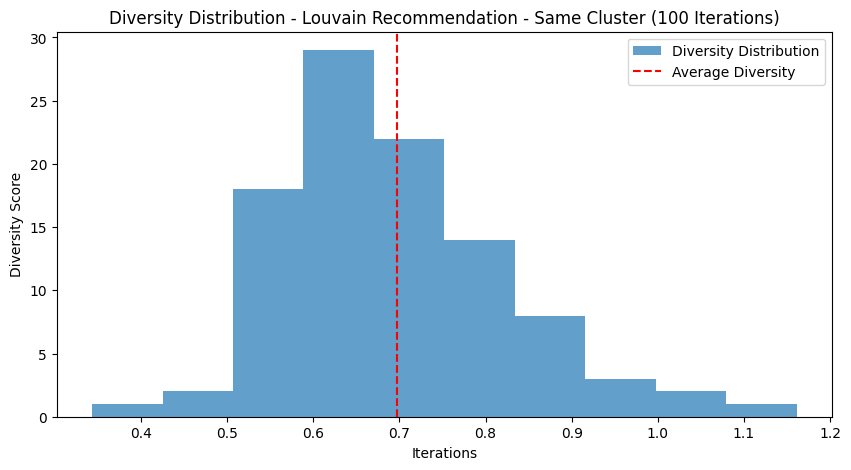

In [12]:
import matplotlib.pyplot as plt

def calculate_diversity(recommendations, feature_columns):
    """
    Calculate feature variance for diversity.
    """
    # Ensure recommendations is a DataFrame
    feature_variance = recommendations[feature_columns].var().mean()
    return feature_variance

def calculate_average_diversity_graph(song_ids, merged_data, feature_columns, recommendation_function, iterations=10):
    """
    Calculate the average diversity of graph-based recommendations for a list of songs over multiple iterations.
    
    Parameters:
        song_ids (list): List of track IDs to generate recommendations for.
        merged_data (DataFrame): The full dataset containing song features.
        feature_columns (list): Columns to calculate diversity.
        recommendation_function (function): Function to generate recommendations for a given song.
        iterations (int): Number of iterations to compute the average diversity.
        
    Returns:
        list: Average diversities for each iteration.
    """
    average_diversities = []
    
    for _ in range(iterations):
        diversities = []
        
        for track_id in song_ids:
            # Get recommendations using the provided recommendation function
            recommendations = recommendation_function(track_id, merged_data, raw=True)
            
            # Calculate diversity for the recommendations
            diversity = calculate_diversity(recommendations, feature_columns)
            diversities.append(diversity)
        
        # Calculate the average diversity for this iteration
        average_diversity = sum(diversities) / len(diversities)
        average_diversities.append(average_diversity)
    
    return average_diversities

# Example song IDs for diversity calculation
song_ids = ['1EzrEOXmMH3G43AXT1y7pA', '6Vc5wAMmXdKIAM7WUoEb7N', '0BUuuEvNa5T4lMaewyiudB']  
feature_columns = ['danceability_x', 'valence_x', 'tempo_x', 'energy_x', 'acousticness_x', 'speechiness_log', 'instrumentalness_log', 'liveness_log']  

# Perform diversity calculations over multiple iterations
diversities_over_iterations = calculate_average_diversity_graph(
    song_ids,
    merged_data,
    feature_columns,
    recommend_same_graph_cluster,  # Pass the Louvain-based recommendation function
    iterations=100
)

# Plot the results
plt.figure(figsize=(10, 5))

# Histogram of diversities
plt.hist(diversities_over_iterations, bins=10, alpha=0.7, label="Diversity Distribution")
plt.axvline(x=sum(diversities_over_iterations) / len(diversities_over_iterations), color="red", linestyle="--", label="Average Diversity")

plt.title("Diversity Distribution - Louvain Recommendation - Same Cluster (100 Iterations)")
plt.xlabel("Iterations")
plt.ylabel("Diversity Score")
plt.legend()
plt.show()


The histogram demonstrates the distribution of diversity scores for song recommendations generated using Louvain clustering over 100 iterations. The majority of the diversity scores are centered around the mean diversity (indicated by the red dashed line), highlighting that the recommendations maintain a moderate level of feature variation while staying cohesive within the same graph cluster. This balance indicates that the Louvain-based system effectively delivers diverse yet contextually relevant song suggestions, aligning with the goal of leveraging graph-based clustering for recommendation systems.

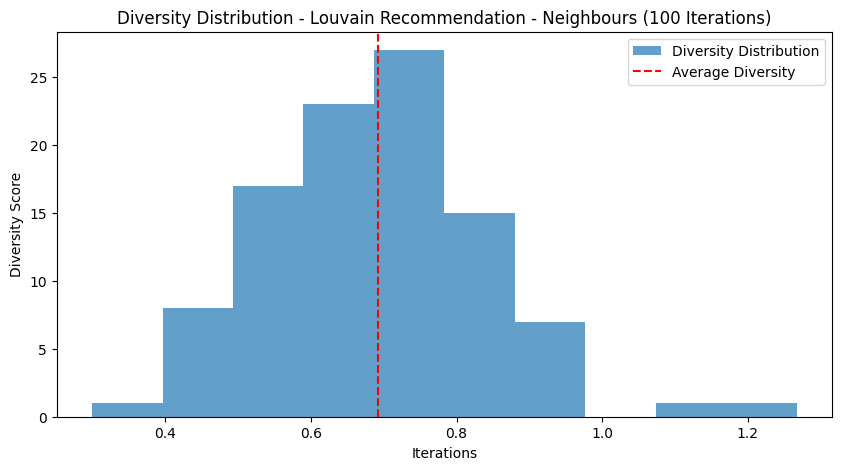

In [66]:
# Perform diversity calculations over multiple iterations
diversities_over_iterations = calculate_average_diversity_graph(
    song_ids,
    merged_data,
    feature_columns,
    recommend_from_graph_neighbors,  # Pass the Louvain-based recommendation function
    iterations=100
)

# Plot the results
plt.figure(figsize=(10, 5))

# Histogram of diversities
plt.hist(diversities_over_iterations, bins=10, alpha=0.7, label="Diversity Distribution")
plt.axvline(x=sum(diversities_over_iterations) / len(diversities_over_iterations), color="red", linestyle="--", label="Average Diversity")

plt.title("Diversity Distribution - Louvain Recommendation - Neighbours (100 Iterations)")
plt.xlabel("Iterations")
plt.ylabel("Diversity Score")
plt.legend()
plt.show()


The histogram illustrates the distribution of diversity scores for song recommendations generated using Louvain clustering across neighboring clusters over 100 iterations. The majority of the diversity scores are centered around the mean diversity (represented by the red dashed line), showcasing that recommendations balance feature variation while exploring songs from adjacent clusters. This approach provides users with suggestions that are not only diverse but also relevant, leveraging the graph-based structure to enhance the breadth of recommendations without compromising contextual similarity.

### Analysis of Diversity Scores

The diversity scores for KMeans and Louvain clustering are as follows:

| **Method**    | **Diversity Score** |
|---------------|---------------------|
| **KMeans**    | 0.5922              |
| **Louvain**   | 0.5727              |

The difference in diversity is small (`~0.02`), suggesting both methods provide similar levels of variety. KMeans clustering offers slightly more diverse recommendations, making it suitable for exploration. In contrast, Louvain clustering focuses on tighter groups, ideal for users seeking closely related tracks.
